# Convolutional Neural Networks for Image Segmentation

**This notebook shows how to create a CNN model for image segmentation with TensorFlow 2 and Keras**

## The Data

Input images:
- RGB ([B4,B3,B2]) bands of the [**Sentinel-2 MSI: MultiSpectral Instrument, Level-1C**](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2) dataset.

Output image:
- Cropland band of the [**USDA NASS Cropland Data Layers**](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL).

**Information**

In this tutorial we will segment Sentilel 2 RGB images into the following semantic classes: `cropland`, `land`, `water`, `urban`.

The `TFRecords` have been created and exported to Google Cloud Store in this [notebook](../0-TFRecords/2-TFRecords_from_GEE.ipynb/#cropland).

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Data exploration](#exploration)
    - #### [Read tha data](#read)
    - #### [Visualize the data](#visualize)
- ### [Create `tf.data.Dataset` from TFRecords](#dataset)
- ### [Create the model](#model)
- ### [Train the model](#train)
- ### [Evaluate the model](#evaluate)
- ### [Predictions](#predictions)
    - ####  [On test dataset](#test)
    - ####  [On training dataset](#training)
- ### [How to improve the model](#improve)

<a id='libraries'></a>
## Python libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

<a id='exploration'></a>
## Data exploration

<a id='read'></a>
### Read the data

In [ ]:
from google.cloud import storage

In [ ]:
client = storage.Client()
bucket_name = 'geo-ai'
bucket = client.get_bucket(bucket_name)

**Get the list of files in the bucket**

In [ ]:
folder = 'Landcover/Data'
file_type = 'tfrecord.gz'

In [ ]:
filelist = []
blobs = bucket.list_blobs(prefix=folder)
for blob in blobs:
    filelist.append(blob.name)   

files = [i for i in filelist if file_type in i]
files = ['gs://'+bucket_name+'/'+i for i in files]

**Get number of records**

In [2]:
nRecords_train = 0
nRecords_test = 0

glob_train = 'gs://geo-ai/Landcover/Data/training_patches' + '*'
glob_test = 'gs://geo-ai/Landcover/Data/test_patches' + '*'

for n, glob in enumerate([glob_train, glob_test]):
    glob = tf.compat.v1.io.gfile.glob(glob)

    for record in tf.data.TFRecordDataset(glob, compression_type='GZIP'):
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        
        if n == 0:
            nRecords_train += 1
        else:
            nRecords_test += 1
    
print('Number of training records:', nRecords_train)
print('Number of test records:', nRecords_test)

Number of training records: 6000
Number of test records: 2000


<a id='visualize'></a>
### Visualize the data

**Read example record**

In [3]:
for record in tf.data.TFRecordDataset(glob, compression_type='GZIP').take(1400):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())

bands = list(dict(example.features.feature).keys())
print('Bands:', bands)

Bands: ['land', 'vis-green', 'vis-red', 'urban', 'water', 'cropland', 'vis-blue', 'landcover']


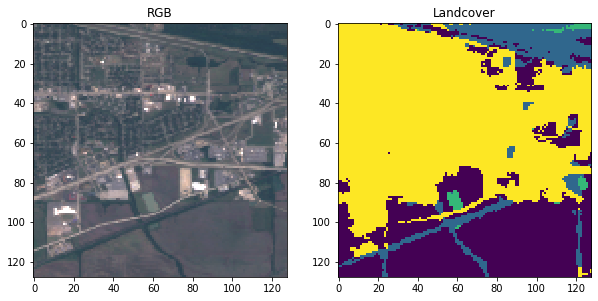

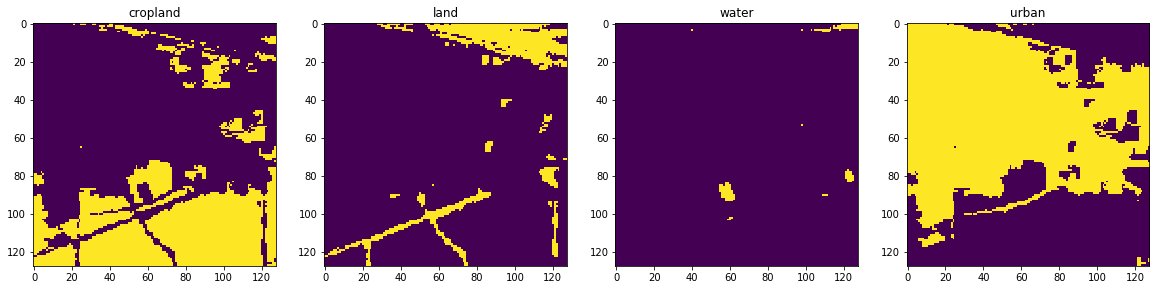

In [4]:
bands = [['vis-red', 'vis-green', 'vis-blue'],['cropland', 'land', 'water', 'urban'], ['landcover']]
classes = ['cropland', 'land', 'water', 'urban']
    
input_image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(128,128,1) for i in bands[0]], axis=2)
output_image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(128,128,1) for i in bands[1]], axis=2)
segmented_image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(128,128) for i in bands[2]], axis=1)

fig, ax = plt.subplots(1,2, figsize=(5*2,5))
ax[0].imshow(input_image.astype(int))
ax[0].set_title('RGB')
ax[1].imshow(segmented_image)
ax[1].set_title('Landcover')

fig, ax = plt.subplots(1,4, figsize=(5*4,5))
for i in range(len(bands[1])):
    ax[i].imshow(output_image[:,:,i])
    ax[i].set_title(classes[i])

<a id='dataset'></a>
## Create `tf.data.Dataset` from TFRecords

**Parse function for data preprocessing**

In [5]:
def parse_function(proto):
    
    # Define your tfrecord 
    bands_input = ['vis-red', 'vis-green', 'vis-blue']
    columns_input = [tf.io.FixedLenFeature([128,128,1], tf.float32) for i in bands_input]

    bands_output = ['cropland', 'land', 'water', 'urban']
    columns_output = [tf.io.FixedLenFeature([128,128,1], tf.float32) for i in bands_output]

    bands = bands_input + bands_output
    columns = columns_input + columns_output
    features = dict(zip(bands, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features)
    
    # Separate the output images from the input images
    label = tf.concat([parsed_features[i] for i in bands_output], axis=2)
    image = tf.concat([parsed_features[i] for i in bands_input], axis=2)
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    return image, label

**Prepare train and test datasets using tf.data**

In [6]:
def create_dataset(glob, shuffle_size, batch_size):
    
    glob = tf.compat.v1.io.gfile.glob(glob)
        
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffle_size)
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    return dataset

In [7]:
batch_size = 32
dataset_train = create_dataset(glob = 'gs://geo-ai/Landcover/Data/training_patches' + '*', shuffle_size=nRecords_train, batch_size=batch_size)
dataset_test = create_dataset(glob = 'gs://geo-ai/Landcover/Data/test_patches' + '*', shuffle_size=nRecords_test, batch_size=batch_size)

In [8]:
dataset_train

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 4)), types: (tf.float32, tf.float32)>

<a id='model'></a>
## Create the model

Here we use the Keras implementation of the [SegNet](https://arxiv.org/pdf/1511.00561.pdf) model. The SegNet well known CNN with a Encoder-Decoder architecture for image segmentation. 

In [9]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Layer, Activation, Reshape, Permute
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D

In [10]:
def create_model(inputShape, nClasses, output_activation='softmax'):
    """
    SegNet model
    ----------
    inputShape : tuple
        Tuple with the dimensions of the input data (ny, nx, nBands). 
    nClasses : int
         Number of classes.
    """

    filter_size = 64
    kernel = (3, 3)        
    pad = (1, 1)
    pool_size = (2, 2)
        

    inputs = Input(shape=inputShape, name= 'image')
        
    # Encoder
    x = Conv2D(64, kernel, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
            
            
    # Decoder
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(64, kernel, padding='same')(x)
    x = BatchNormalization()(x)
            
    x = Conv2D(nClasses, (1, 1), padding='valid')(x)
    
    outputs = Activation(output_activation, name= 'output')(x)
        
    model = Model(inputs=inputs, outputs=outputs, name='segnet')
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
        
    return model

In [11]:
model = create_model(inputShape = input_image.shape, nClasses=output_image.shape[2], output_activation='sigmoid')

print('Output shape:', model.output_shape)

Output shape: (None, 128, 128, 4)


In [12]:
model.summary()

Model: "segnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512  

<a id='train'></a>
## Train the model

In [13]:
nEpoch = 25
nStep_train = (int)(nRecords_train/batch_size)
nStep_test = (int)(nRecords_test/batch_size)

In [ ]:
model.fit(dataset_train, 
          epochs=nEpoch, 
          validation_data=dataset_test, 
          steps_per_epoch=nStep_train, 
          validation_steps=nStep_test)

**Save/Read models**

In [ ]:
#model.save('segmentation_model.h5')

In [14]:
model.load_weights('segmentation_model.h5')

**Save/Read metrics history**

In [ ]:
#metrics = pd.DataFrame(model.history.history)

In [ ]:
#import json
## save to json:  
#hist_json_file = 'segmentation_history.json' 
#with open(hist_json_file, mode='w') as f:
#    metrics.to_json(f)

In [15]:
metrics = pd.read_json('segmentation_history.json')

<a id='evaluate'></a>
## Evaluate the model

- **Plot loss**

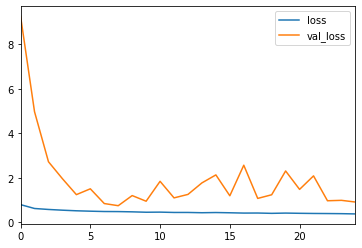

In [16]:
metrics[['loss', 'val_loss']].plot()

- **Plot accuracy**

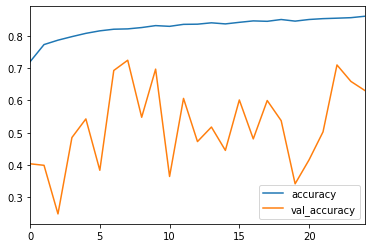

In [17]:
metrics[['accuracy', 'val_accuracy']].plot()

<a id='predictions'></a>
## Predictions

<a id='test'></a>
###  On test dataset

**Read example record**

In [18]:
glob_test = 'gs://geo-ai/Landcover/Data/test_patches' + '*'
glob = tf.compat.v1.io.gfile.glob(glob_test)

bands = [['vis-red', 'vis-green', 'vis-blue'],['landcover']]


for record in tf.data.TFRecordDataset(glob, compression_type='GZIP').take(1400):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())

    input_image = np.concatenate([np.array(example.features.feature[j].float_list.value).reshape(1,128,128,1) for j in bands[0]], axis=3)
    output_image = np.concatenate([np.array(example.features.feature[j].float_list.value).reshape(128,128) for j in bands[1]], axis=1)        

**Normalize input images**

In [19]:
input_image = input_image/255.

**Predict single record**

In [20]:
prediction = model.predict(input_image)

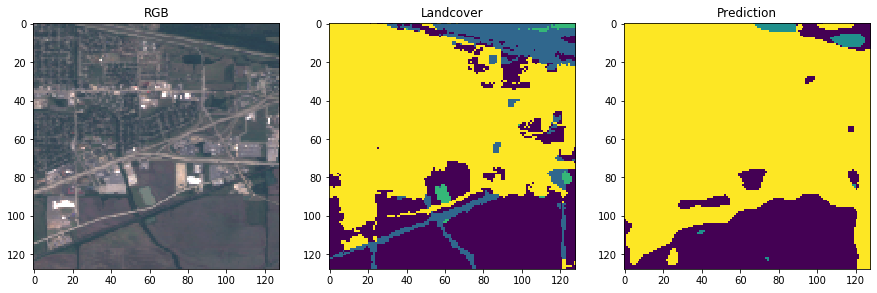

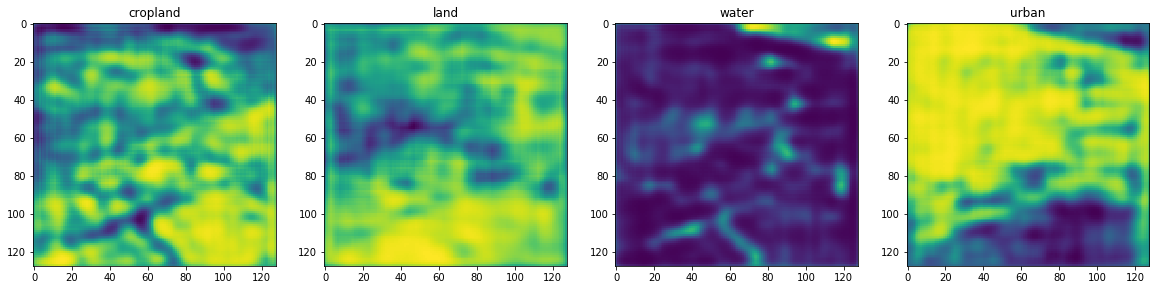

In [21]:
segmented_image = np.ones((prediction.shape[1], prediction.shape[2])) 

for i in range(prediction.shape[-1]):
    segmented_image[prediction[0,:,:, i] > 0.5] = i

fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow((input_image[0,:,:,:]*255.0).astype(int))
ax[0].set_title('RGB')
ax[1].imshow(output_image)
ax[1].set_title('Landcover')
ax[2].imshow(segmented_image)
ax[2].set_title('Prediction')

fig, ax = plt.subplots(1,4, figsize=(5*4,5))
for i in range(4):
    ax[i].imshow(prediction[0,:,:,i])
    ax[i].set_title(classes[i])

<a id='training'></a>
###  On training dataset

**Read example record**

In [22]:
glob_test = 'gs://geo-ai/Landcover/Data/training_patches' + '*'
glob = tf.compat.v1.io.gfile.glob(glob_test)

bands = [['vis-red', 'vis-green', 'vis-blue'],['landcover']]


for record in tf.data.TFRecordDataset(glob, compression_type='GZIP').take(1400):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())

    input_image = np.concatenate([np.array(example.features.feature[j].float_list.value).reshape(1,128,128,1) for j in bands[0]], axis=3)
    output_image = np.concatenate([np.array(example.features.feature[j].float_list.value).reshape(128,128) for j in bands[1]], axis=1)  

**Normalize input images**

In [23]:
input_image = input_image/255.

**Predict single record**

In [24]:
prediction = model.predict(input_image)

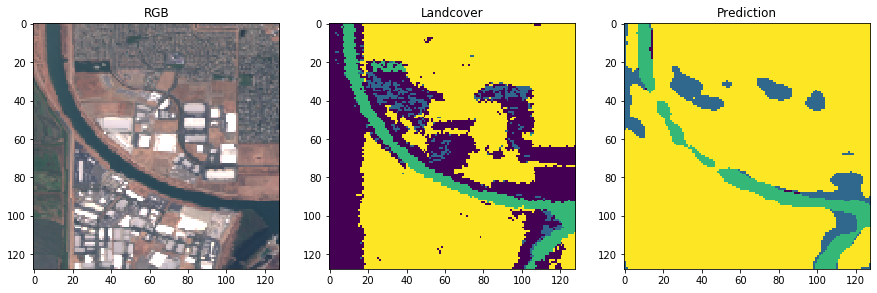

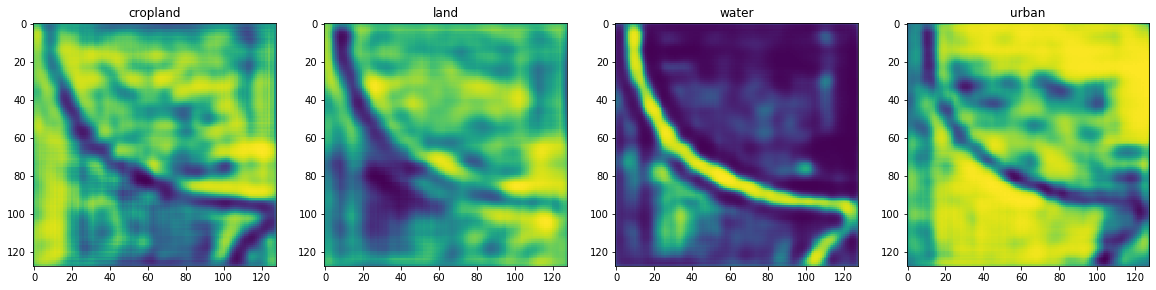

In [25]:
segmented_image = np.ones((prediction.shape[1], prediction.shape[2])) 

for i in range(prediction.shape[-1]):
    segmented_image[prediction[0,:,:, i] > 0.5] = i

fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow((input_image[0,:,:,:]*255.0).astype(int))
ax[0].set_title('RGB')
ax[1].imshow(output_image)
ax[1].set_title('Landcover')
ax[2].imshow(segmented_image)
ax[2].set_title('Prediction')

fig, ax = plt.subplots(1,4, figsize=(5*4,5))
for i in range(4):
    ax[i].imshow(prediction[0,:,:,i])
    ax[i].set_title(classes[i])

<a id='improve'></a>
## How to improve the model
- Add more data from diffenernt regionds.
- Add more input bands (e.g.: NIR, NDVI, NDWI).
- Add more input semantic classes.
- Try with other models (e.g.: [PSPNet](https://arxiv.org/abs/1612.01105), [Large Kernel Matters](https://arxiv.org/abs/1703.02719), [DeepLab v3](https://arxiv.org/abs/1706.05587)).
- Use composites from different seasons and try a [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN).